<a href="https://colab.research.google.com/github/gabrieladamasceno/Attacks_5G/blob/main/MLP_Bin%C3%A1rio_Zero_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Acessar dataset
drive.mount('/content/gdrive')

# Carregar o dataset
encoded = pd.read_csv("/content/gdrive/MyDrive/Datasets/Attacks/Encoded/Encoded.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install imbalanced-learn


In [3]:
!pip install --upgrade tensorflow
!pip install --upgrade keras

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [5]:
# Usando shape
num_amostras = encoded.shape[0]
print(f"Número de amostras: {num_amostras}")

# Usando len()
num_amostras_len = len(encoded)
print(f"Número de amostras (usando len): {num_amostras_len}")

Número de amostras: 1215890
Número de amostras (usando len): 1215890


In [6]:
# Exibir os nomes de todas as colunas
colunas = encoded.columns.tolist()  # Converte o Index em uma lista
print("Nomes das colunas:")
for coluna in colunas:
    print(coluna)

Nomes das colunas:
Unnamed: 0
Seq
Dur
RunTime
Mean
Sum
Min
Max
sTos
dTos
sTtl
dTtl
sHops
dHops
TotPkts
SrcPkts
DstPkts
TotBytes
SrcBytes
DstBytes
Offset
sMeanPktSz
dMeanPktSz
Load
SrcLoad
DstLoad
Loss
SrcLoss
DstLoss
pLoss
SrcGap
DstGap
Rate
SrcRate
DstRate
SrcWin
DstWin
sVid
dVid
SrcTCPBase
DstTCPBase
TcpRtt
SynAck
AckDat
Label
Attack Type
Attack Tool
 *        
 *    V   
 *    f   
 e        
 e    f   
 e &      
 e *      
 e d      
 e g      
 e i      
 e r      
 e s      
 eU       
e        
arp
icmp
ipv6-icmp
llc
lldp
sctp
tcp
udp
ACC
CON
ECO
FIN
INT
NRS
REQ
RSP
RST
TST
URP
Shutdown
Start
Status
39
4
52
54
af11
af12
af41
cs0
cs4
cs6
cs7
ef
nan


In [7]:
# Selecionar apenas colunas numéricas
numeric_cols = encoded.select_dtypes(include=['number']).columns

# Aplicar a suavização apenas nas colunas numéricas
for col in numeric_cols:
    encoded[col] = encoded[col].fillna(encoded[col].mean())

In [8]:
# columns with null values

columns_null = []
columns = encoded.columns
for column in columns:
    c = encoded[column].isnull().sum()
    if c != 0:
        print(column, 'has {} null values'.format(c))
        columns_null.append(column)

Features
* Seq: Sequência de pacotes.
* Offset: Deslocamento em bytes.
* sTtl: Time to Live da fonte.
* tcp: Indica se o protocolo TCP está sendo usado.
* AckDat: Dados de reconhecimento.
* RST: Sinalizador de reinício TCP.
* INT: Interrupções no fluxo de dados.
* TcpRtt: Tempo de ida e volta do TCP.
* icmp: Indica se o protocolo ICMP está presente.
* sMeanPktSz: Tamanho médio do pacote da fonte.
* FIN: Sinalizador de finalização de conexão.
* sHops: Número de saltos até o destino.
* Mean: Valor médio de um conjunto de dados.
* dTtl: Time to Live do destino.
* SrcBytes: Bytes enviados da fonte.
* TotBytes: Total de bytes.
* dMeanPktSz: Tamanho médio do pacote do destino.
* Status: Estado da conexão.
* cs0: Parâmetro de controle.
* SrcWin: Janela de origem TCP.
* sTos: Tipo de serviço.
* CON: Conexões.
* REQ: Requisições.
* Loss: Taxa de perda de pacotes.

In [9]:

import pandas as pd

# Selecionar apenas as colunas 'Label' e 'Attack Type'
icmp_flood_samples = encoded[['Label', 'icmp', 'Attack Type']]

icmp_flood_samples

,Label,icmp,Attack Type
0,Benign,1.0,Benign
1,Benign,1.0,Benign
2,Benign,0.0,Benign
3,Benign,0.0,Benign
4,Benign,0.0,Benign
...,...,...,...
1215885,Benign,0.0,Benign
1215886,Benign,0.0,Benign
1215887,Benign,0.0,Benign
1215888,Benign,0.0,Benign


In [10]:
import psutil
import time
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Função para monitorar recursos
def monitor_resource_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    cpu_percent = psutil.cpu_percent(interval=0.1)
    memory_usage_mb = memory_info.rss / (1024 * 1024)
    return cpu_percent, memory_usage_mb

# Callback personalizado para monitorar CPU e memória
class ResourceMonitor(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Antes da época começar
        self.start_time = time.time()
        self.start_cpu, self.start_memory = monitor_resource_usage()
        print(f"\n[Início da Época {epoch + 1}]")
        print(f"CPU inicial: {self.start_cpu:.2f}%, Memória inicial: {self.start_memory:.2f} MB")

    def on_epoch_end(self, epoch, logs=None):
        # Após a época terminar
        end_time = time.time()
        end_cpu, end_memory = monitor_resource_usage()
        elapsed_time = end_time - self.start_time
        memory_diff = end_memory - self.start_memory

        print(f"[Fim da Época {epoch + 1}]")
        print(f"CPU final: {end_cpu:.2f}%, Memória consumida: {memory_diff:.2f} MB, Tempo gasto: {elapsed_time:.2f} segundos")

# Instanciar o callback
resource_monitor = ResourceMonitor()

# Parâmetros para early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from keras.regularizers import l2

# Configuração das features e rótulos
features = [
    'Seq', 'Offset', 'sTtl', 'tcp', 'AckDat', 'RST', 'INT', 'TcpRtt', 'icmp',
    'sMeanPktSz', 'FIN', 'sHops', 'Mean', 'dTtl', 'SrcBytes', 'TotBytes',
    'dMeanPktSz', 'Status', 'cs0', 'SrcWin', 'sTos', 'CON', 'REQ', 'Loss'
]

X = encoded[features]
y = encoded['Label']  # Coluna de rótulos

# Filtrar as amostras zero-day (ICMPFlood)
zero_day_data = encoded[encoded['Attack Type'] == 'ICMPFlood']
non_zero_day_data = encoded[encoded['Attack Type'] != 'ICMPFlood']

# Dividir o conjunto com zero-day para teste
X_zero_day = zero_day_data[features]
y_zero_day = zero_day_data['Label']

# Dividir o conjunto não-zero-day (benignos e maliciosos) para treinamento
X_non_zero_day = non_zero_day_data[features]
y_non_zero_day = non_zero_day_data['Label']

# Dividir o conjunto de treino e teste (sem zero-day no treino)
X_train_non_zero_day, X_test_non_zero_day, y_train_non_zero_day, y_test_non_zero_day = train_test_split(
    X_non_zero_day, y_non_zero_day, test_size=0.3, random_state=42, stratify=y_non_zero_day
)

# Concatenar as amostras zero-day no conjunto de teste
X_test_combined = pd.concat([X_test_non_zero_day, X_zero_day])
y_test_combined = pd.concat([y_test_non_zero_day, pd.Series(y_zero_day, name='Label')])

# Verificar a distribuição das classes no conjunto de teste
print(f"Zero-day presente no conjunto de teste: {any(zero_day_data.index.isin(X_test_combined.index))} \n")

# Verificar as distribuições
print("Distribuição do conjunto de treino binário:", pd.Series(y_train_non_zero_day).value_counts())
print("Distribuição do conjunto de teste binário:", pd.Series(y_test_combined).value_counts())

Zero-day presente no conjunto de teste: True 

Distribuição do conjunto de treino binário: Label
Malicious    515898
Benign       334416
Name: count, dtype: int64
Distribuição do conjunto de teste binário: Label
Malicious    222255
Benign       143321
Name: count, dtype: int64


In [12]:
y_test_combined

,Label
400968,Benign
334235,Benign
984001,Malicious
824055,Malicious
539501,Malicious
...,...
766850,Malicious
766851,Malicious
766858,Malicious
766861,Malicious


In [14]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd

# Configurar o SMOTE
smote = SMOTE(random_state=42)

# Aplicar SMOTE no conjunto de treinamento
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_non_zero_day, y_train_non_zero_day)

# Verificar distribuição das classes após o SMOTE
print(f"Distribuição após SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")

# Normalizar os dados após o SMOTE
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train_balanced)

# Normalizar o conjunto de teste com o mesmo scaler ajustado no treino
X_test_combined = scaler.transform(X_test_combined)

Distribuição após SMOTE:
Label
Malicious    515898
Benign       515898
Name: count, dtype: int64


'\n# Normalizar os dados após o SMOTE\nscaler = StandardScaler()\nX_train_balanced = scaler.fit_transform(X_train_non_zero_day)\n\n# Normalizar o conjunto de teste com o mesmo scaler ajustado no treino\nX_test_combined = scaler.transform(X_test_combined)\n'

In [15]:
# Verificar a dimensão do treino sem balancear
#print(X_train_non_zero_day.shape)
#print(y_train_non_zero_day.shape)
#print(f"Distribuição sem balancear:\n{pd.Series(y_train_non_zero_day).value_counts()}")

# Verificar a dimensão do teste
print(X_test_combined.shape)
print(y_test_combined.shape)
print(f"Distribuição Teste:\n{pd.Series(y_test_combined).value_counts()}")

(365576, 24)
(365576,)
Distribuição Teste:
Label
Malicious    222255
Benign       143321
Name: count, dtype: int64


In [89]:
from sklearn.preprocessing import LabelEncoder

# Criar o codificador
label_encoder = LabelEncoder()

# Ajustar o codificador aos rótulos de treinamento e teste
y_train_balanced = label_encoder.fit_transform(y_train_balanced)
y_test_combined = label_encoder.transform(y_test_combined)

# Verificar os tipos após a transformação
print(y_train_balanced.dtype)
print(y_test_combined.dtype)

int64
int64


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Construção do Modelo
model = Sequential()
model.add(Input(shape=(X_train_balanced.shape[1],)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_combined, y_test_combined),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, resource_monitor, reduce_lr]
)


[Início da Época 1]
CPU inicial: 0.10%, Memória inicial: 3833.38 MB
Epoch 1/10
32224/32244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9619 - loss: 0.2139[Fim da Época 1]
CPU final: 0.00%, Memória consumida: 135.31 MB, Tempo gasto: 83.34 segundos
32244/32244 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9619 - loss: 0.2138 - val_accuracy: 0.9925 - val_loss: 0.0624 - learning_rate: 1.0000e-04

[Início da Época 2]
CPU inicial: 0.20%, Memória inicial: 3968.69 MB
Epoch 2/10
32228/32244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0447[Fim da Época 2]
CPU final: 0.20%, Memória consumida: 46.25 MB, Tempo gasto: 80.85 segundos
32244/32244 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9944 - loss: 0.0447 - val_accuracy: 0.9943 - val_loss: 0.0548 - learning_rate: 1.0000e-04

[Início da Época 3]
CPU inicial: 0.10%, Memória inicial: 4014.95 MB
Epoch 3/10
32222/32244 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0331[Fim da Época 3]
CPU final: 0.40%, Memóri

In [18]:
# Passo 1: Obter as previsões para as amostras zero-day
y_pred_zero_day = (model.predict(X_zero_day) > 0.5).astype(int)

# Passo 2: Verificar se todas as previsões para zero-day são 1 (maliciosas)
zero_day_correct = (y_pred_zero_day == 1)

# Passo 3: Mostrar o número de previsões incorretas (caso o modelo tenha classificado como benignas)
incorrect_zero_day_predictions = sum(y_pred_zero_day != 1)
print(f"A quantidade de amostras zero-day classificadas incorretamente como benignas (classe 0): {incorrect_zero_day_predictions}")

# Passo 4: Exibir as amostras que foram classificadas incorretamente
incorrect_zero_day_samples = X_zero_day[~zero_day_correct]
print("Amostras zero-day incorretamente classificadas como benignas:")
print(incorrect_zero_day_samples)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
A quantidade de amostras zero-day classificadas incorretamente como benignas (classe 0): [910]
Amostras zero-day incorretamente classificadas como benignas:
         Seq  Offset  sTtl  tcp  AckDat  RST  INT  TcpRtt  icmp  sMeanPktSz  \
34416    885  148844  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34422    887  149468  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34426    891  149876  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34430    895  150400  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34435    899  151016  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
...      ...     ...   ...  ...     ...  ...  ...     ...   ...         ...   
765532  2161  469224  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765535  2162  469508  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765540  2166  470216  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765543  2167  

In [19]:
# Passo 1: Obter as previsões para as amostras zero-day
y_pred_zero_day = model.predict(X_zero_day)  # A previsão do modelo, que é uma probabilidade

# Passo 2: Verificar se as previsões para zero-day são 1 (maliciosas)
# Aqui, estamos considerando as previsões como malignas se a probabilidade for maior que 0.5
y_pred_zero_day_class = (y_pred_zero_day > 0.5).astype(int)

# Passo 3: Verificar quais previsões foram incorretas
# O modelo classifica como benignas (0) quando a probabilidade é menor que 0.5, mas queremos identificar as incorretas
incorrect_zero_day_predictions = sum(y_pred_zero_day_class != 1)

print(f"A quantidade de amostras zero-day classificadas incorretamente como benignas (classe 0): {incorrect_zero_day_predictions}")

# Passo 4: Exibir as amostras que foram classificadas incorretamente
# Selecionar as amostras onde a previsão foi incorreta (não igual a 1, ou seja, classificadas como benignas)
incorrect_zero_day_samples = X_zero_day[y_pred_zero_day_class != 1]

print("Amostras zero-day incorretamente classificadas como benignas:")
print(incorrect_zero_day_samples)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
A quantidade de amostras zero-day classificadas incorretamente como benignas (classe 0): [910]
Amostras zero-day incorretamente classificadas como benignas:
         Seq  Offset  sTtl  tcp  AckDat  RST  INT  TcpRtt  icmp  sMeanPktSz  \
34416    885  148844  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34422    887  149468  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34426    891  149876  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34430    895  150400  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
34435    899  151016  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
...      ...     ...   ...  ...     ...  ...  ...     ...   ...         ...   
765532  2161  469224  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765535  2162  469508  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765540  2166  470216  63.0  0.0     0.0  0.0  0.0     0.0   1.0        42.0   
765543  2167 

In [20]:
#!pip install scikit-learn==1.2.2 # Certifique-se de ter o scikit-learn instalado
from sklearn.ensemble import IsolationForest

In [91]:
# X_train_known: Dados de treinamento benignos + ataques conhecidos
# y_train_known: Rótulos correspondentes (0 para benigno, 1 para ataques conhecidos)

# Filtrar dados benignos e ataques conhecidos
X_train_known = X_train_balanced
y_train_known = y_train_balanced

# Criar e treinar o Isolation Forest
isolation_forest = IsolationForest(contamination='auto', random_state=42)
isolation_forest.fit(X_train_known)

IsolationForest(random_state=42)

In [93]:
import pandas as pd
anomaly_scores = isolation_forest.decision_function(X_test_combined)

In [108]:
threshold = 0.128

In [109]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred = [1 if score < threshold else 0 for score in anomaly_scores]

# Matriz de Confusão
cm = confusion_matrix(y_test_combined, y_pred)
print("Matriz de Confusão:\n", cm)

# Relatório de Classificação
print("\nRelatório de Classificação:\n", classification_report(y_test_combined, y_pred))

# AUC
auc = roc_auc_score(y_test_combined, y_pred)
print("\nAUC:", auc)

# Avaliação específica para zero-day (ajuste os índices conforme necessário)
zero_day_indices = np.where(y_test_combined == 1)[0]  # Índices das amostras zero-day
zero_day_pred = [y_pred[i] for i in zero_day_indices]  # Previsões para as amostras zero-day

zero_day_detection_rate = sum(zero_day_pred) / len(zero_day_pred)
print("\nTaxa de Detecção de Zero-day:", zero_day_detection_rate)

Matriz de Confusão:
 [[ 14649 128672]
 [ 80322 141933]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.15      0.10      0.12    143321
           1       0.52      0.64      0.58    222255

    accuracy                           0.43    365576
   macro avg       0.34      0.37      0.35    365576
weighted avg       0.38      0.43      0.40    365576


AUC: 0.3704077131783241

Taxa de Detecção de Zero-day: 0.6386043058648849


In [96]:
import numpy as np
from sklearn.metrics import roc_curve

# Calcula a curva ROC
fpr, tpr, thresholds = roc_curve(y_test_combined, anomaly_scores)

# Calcula o Youden's J statistic
J = tpr - fpr

# Encontra o índice do melhor threshold
best_threshold_index = np.argmax(J)

# Obtém o melhor threshold
best_threshold = thresholds[best_threshold_index]

print("Melhor threshold:", best_threshold)

Melhor threshold: 0.12942780347919175


In [110]:
from sklearn.metrics import f1_score

f1_scores = []
for threshold in thresholds:
    y_pred_binary = [1 if score < threshold else 0 for score in anomaly_scores]
    f1 = f1_score(y_test_combined, y_pred_binary)
    f1_scores.append(f1)

best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

print("Melhor threshold:", best_threshold)

KeyboardInterrupt: 

11425/11425 ━━━━━━━━━━━━━━━━━━━━ 10s 852us/step


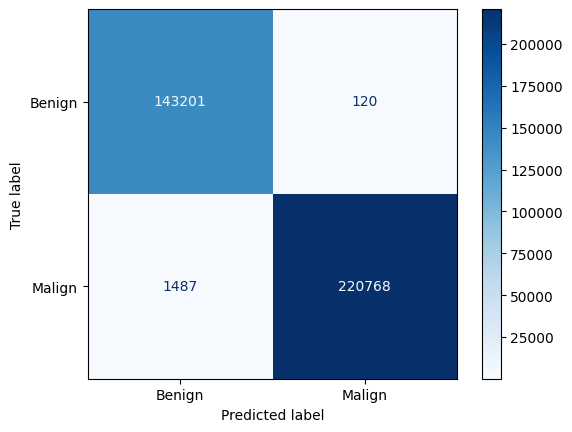

In [40]:
y_test = y_test_combined

#Matriz de Confusão

y_pred = model.predict(X_test_combined)
y_pred_classes = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malign"])
disp.plot(cmap='Blues')

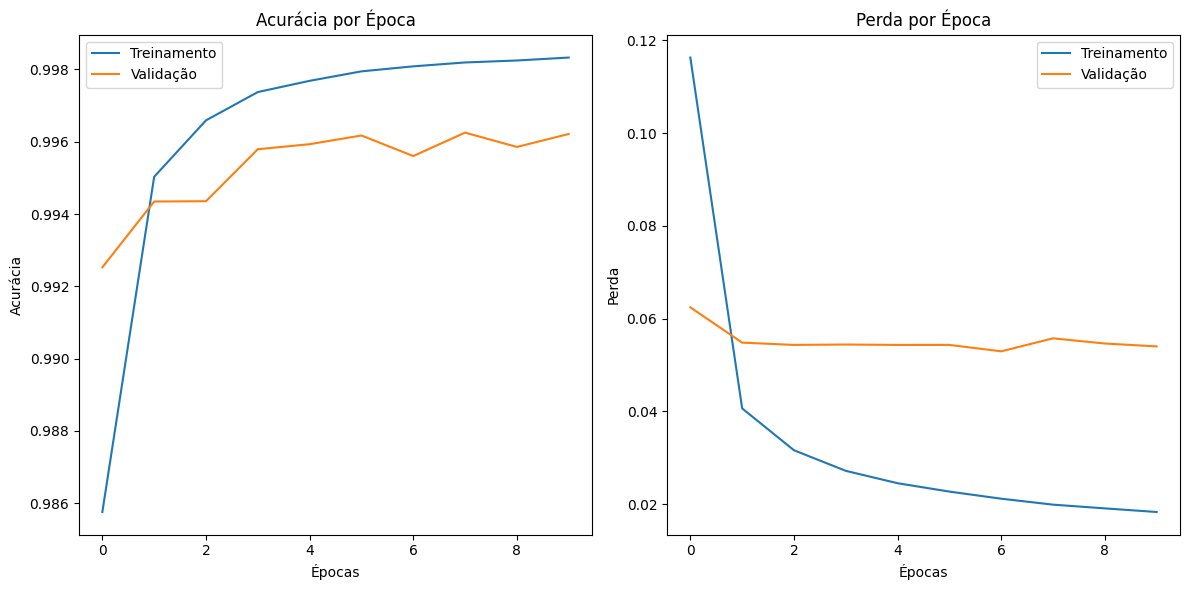

In [35]:
# Gráfico de Acurácia
plt.figure(figsize=(12, 6))

# Acurácia de treino
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Supondo que 'model' seja seu modelo treinado
y_pred_prob = model.predict(X_test_combined).flatten()  # Usando .flatten() para transformar em um vetor 1D

11425/11425 ━━━━━━━━━━━━━━━━━━━━ 10s 837us/step


In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

In [43]:
roc_auc = auc(fpr, tpr)

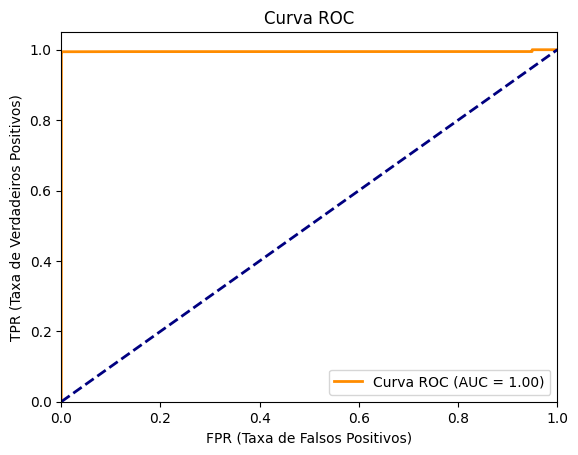

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular a AUC
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linha diagonal (chance aleatória)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (Taxa de Falsos Positivos)')
plt.ylabel('TPR (Taxa de Verdadeiros Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()